Let's train a simple deep-Q RL agent on a simple chemical engineering problem "PFR or CSTR" - 
see report PDF for specification of this problem

In [13]:
!pip install tensorflow==1.14
!pip install keras==2.3.1
!pip install keras-rl

     |████████████████████████████████| 109.2MB 46kB/s 
     |████████████████████████████████| 491kB 40.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 3.2MB 12.4MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


     |████████████████████████████████| 378kB 4.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


# A "Restart Runtime" button should pop up in the above cell. Press This.
# After this we can now import the github repository and begin

In [1]:
!git clone https://github.com/lollcat/RL-Process-Design
# First Clone the github repo

Cloning into 'RL-Process-Design'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1288 (delta 96), reused 58 (delta 31), pack-reused 1104
Receiving objects: 100% (1288/1288), 19.37 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (764/764), done.


['BFD.gif',
 'Learning.gif',
 'README.md',
 'crop.gif',
 'PFRorCSTR.py',
 'package-list.txt',
 'reactor_sequence',
 'Untitled.ipynb',
 'trim.gif',
 'PFRCSTRconversion.gif',
 'Agent.ipynb',
 'Livenspiel.gif']

In [4]:
import tensorflow as tf
tf.__version__ # this should return "1.14.0"

'1.14.0'

In [3]:
import os
os.chdir('RL-Process-Design/Discrete/PFR or CSTR')
os.listdir()

['BFD.gif',
 'Learning.gif',
 'README.md',
 'crop.gif',
 'PFRorCSTR.py',
 'package-list.txt',
 '__pycache__',
 'reactor_sequence',
 'Ideal_Soln.png',
 'Untitled.ipynb',
 'trim.gif',
 'PFRCSTRconversion.gif',
 'Agent.ipynb',
 'Livenspiel.gif']

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML, Image
#matplotlib.rcParams['figure.dpi']= 100

from scipy import integrate
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.optimizers import Adam
from keras.models import load_model

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

the above code throws warnings, but this is not a problem

In [7]:
from PFRorCSTR import simulator # this is the RL environment

In [8]:
env = simulator(volume = 0.8, n_reactors=4)
nb_actions = env.action_space.n
env.observation_space.shape, env.action_space.n, # state space is observation of the input conversion, action space is discrete(2) representing "PFR or CSTR"

((1,), 2)

# Let's look at the ideal solution

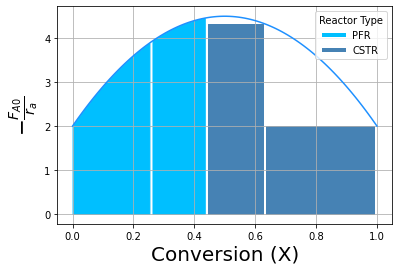

In [9]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
plt.plot(X, Y, color = "dodgerblue")
plt.xlabel("Conversion (X)", fontsize=label_size)
plt.ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
plt.grid(True)

previous_index = 0
conversion = 0
X_out_PFR = []
X_out_CSTR = []
X_react = []
Y_react = []
color = []

while conversion < 0.4:
    conversion = env.equation_solver(1, conversion)
    X_out_PFR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(Y[previous_index:index])
    previous_index = index
    color.append("deepskyblue")
  
while conversion > 0.4 and conversion <= 0.9:
    conversion = env.equation_solver(0, conversion)
    X_out_CSTR.append(conversion)
    index = np.where(abs(X - conversion) == min(abs(X - conversion)))[0][0]
    X_react.append(X[previous_index:index])
    Y_react.append(np.zeros(X_react[-1].shape) + Y[index])
    previous_index = index
    color.append("steelblue")



for i in range(len(X_react)):
    plt.fill_between(X_react[i], Y_react[i], color = color[i])

    
legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='PFR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='CSTR')] 

plt.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
plt.savefig('Ideal_Soln.png', bbox_inches='tight')

## Doube check volumes are correct to make sure simulator solver is working

In [10]:
def PFR(x):
    return -10*x**2 + 10*x + 2
def CSTR_vol(x, x_in):
    return (-10*x**2 + 10*x + 2)*(x - x_in)

PFR1 = integrate.quad(PFR, 0,  X_out_PFR[0])[0]
PFR2 = integrate.quad(PFR, X_out_PFR[0], X_out_PFR[1] )
CSTR1 = CSTR_vol(X_out_CSTR[0], X_out_PFR[-1])


PFR1, PFR2, CSTR1

(0.7999999999999999,
 (0.8000000000000004, 8.881784197001257e-15),
 0.8000000000000009)

# Let's Build and Train the Model

In [11]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 610
Trainable params: 610
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
steps = 15000
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.05, value_test=0, nb_steps=steps)
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=9,
target_model_update=1e-2, policy=policy, gamma = 0.95)
optimizer = Adam(lr=1e-3)
dqn.compile(optimizer=optimizer, metrics=['mae'])

In [16]:
# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
hist = dqn.fit(env, nb_steps=steps)

Training for 15000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 29:29 - reward: 0.2601

/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 110s 11ms/step - reward: 0.2175
2500 episodes - episode_reward: 0.870 [0.769, 1.000] - loss: 0.000 - mae: 0.263 - mean_q: 0.538 - mean_eps: 0.683

Interval 2 (10000 steps performed)
 4996/10000 [=============>................] - ETA: 53s - reward: 0.2381done, took 163.339 seconds


In [17]:
reward_data = np.array(hist.history["episode_reward"])
print(hist.history.keys())

# A variety of visualisations of the solution found by the agent are given below

## First let's look at the history of the performance across episodes

In [22]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

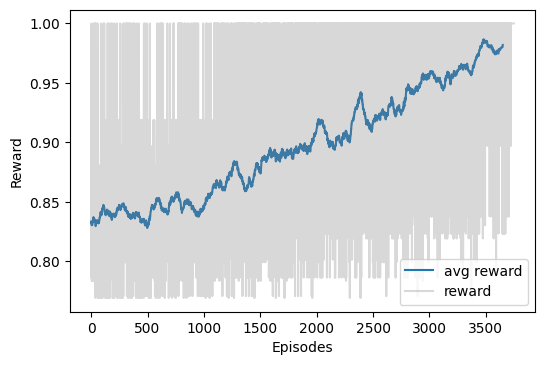

In [90]:
smoothed_rews = running_mean(reward_data, 100)
plt.plot(np.arange(np.shape(smoothed_rews)[0])[-len(smoothed_rews):], smoothed_rews)
plt.plot(np.arange(np.shape(reward_data)[0]),reward_data,color='grey', alpha=0.3)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"], loc=4)
plt.savefig('Learning.png', bbox_inches='tight')

In [89]:
fig, ax = plt.subplots()
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward")
ax.set_xlim(0,4000)
ax.set_ylim(0.75, 1)
interval = 30

lines = []
line1, = ax.plot([], [])
lines.append(line1)
line2, = ax.plot([], [],color='grey', alpha=0.3)
lines.append(line2)
ax.legend(["avg reward", "reward"], loc=4 )
plt.close()
def init():
    for line in lines:
        line.set_data([],[])
    return lines
def anim(i):
    smoothed_rews_ = smoothed_rews[0:i*interval]
    reward_data_ = reward_data[0:i*interval]
    lines[0].set_data(np.arange(np.shape(smoothed_rews_)[0])[-len(smoothed_rews_):], smoothed_rews_)
    lines[1].set_data(np.arange(np.shape(reward_data_)[0]),reward_data_)
    return lines
anim_Learn = animation.FuncAnimation(fig, anim, frames = round(len(smoothed_rews)/interval), init_func=init, interval = 100, blit = True)

rc('animation', html='html5')
anim_Learn

In [29]:
# list choices over episode
dqn.test(env, visualize = True)

Testing for 1 episodes ...
choice(1) - conversions: [0, 0.2601494936395941], reactors: [1]
choice(2) - conversions: [0, 0.2601494936395941, 0.44804425979999357], reactors: [1, 1]
choice(3) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981], reactors: [1, 1, 0]
choice(4) - conversions: [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1], reactors: [1, 1, 0, 0]
Episode 1: reward: 1.000, steps: 4


In [30]:
env.reactor_seq, env.X

([1, 1, 0, 0],
 [0, 0.2601494936395941, 0.44804425979999357, 0.6331085954859981, 1])

In [31]:
y = [] 
x = []
CSTR = []
PFR = []
for i in range(0, 100):
    x.append(i/140)
    CSTR.append(env.equation_solver(0, x[i]))
    PFR.append(env.equation_solver(1, x[i]))
x_sim = env.X[0:-1]
choice = env.X[1:]

In [88]:
fig, ax = plt.subplots()
ax.plot(x, CSTR)
ax.plot(x, PFR)
ax.legend(["CSTR", "PFR", "CHOICE"])
ax.set_xlabel("Inlet Conversion")
ax.set_ylabel("Outlet Conversion")
line, = ax.plot([], [], '--go', lw=2)
plt.close()
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    line.set_data(x_sim[0:i+1], choice[0:i+1])
    return (line,)
rc('animation', html='html5')
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(x_sim), interval = 1000, blit = True)
anim

## Plot animation of livenspiel plot

In [87]:
label_size = 20
X = np.linspace(0, 1, 100)
Y = -10*X**2 + 10*X + 2
fig, ax = plt.subplots()
ax.plot(X, Y, color = "dodgerblue")
ax.set_xlabel("Conversion (X)", fontsize=label_size)
ax.set_ylabel(r"$ - \frac{F_{A0}}{r_a} $", fontsize=label_size)
ax.grid(True)


legend_elements = [matplotlib.lines.Line2D([0], [0], c="deepskyblue", lw=4, label='CSTR'),
                   matplotlib.lines.Line2D([0], [0], c="steelblue", lw=4, label='PFR')] 

ax.legend(handles = legend_elements, title = "Reactor Type", loc = 1)
fills = [ax.fill_between([], [])]
plt.close()

def livenspiel_plotter(conversion_in, conversion_out, choice, X_data, Y_data, ax):
    index_in = np.where(abs(X_data - conversion_in) == min(abs(X_data - conversion_in)))[0][0]
    index_out = np.where(abs(X_data - conversion_out) == min(abs(X_data - conversion_out)))[0][0]
    x = X_data[index_in:index_out]
    if choice == 0: # CSTR
        y = np.zeros(x.shape) + Y_data[index_out]
        fill = ax.fill_between(x, y, color = "deepskyblue")
        
    if choice == 1: # PFR
        y = Y_data[index_in:index_out]
        fill = ax.fill_between(x, y, color = "steelblue")
    
    fills.append(fill)    
    return fills
def animate(i):
    fills = livenspiel_plotter(env.X[i], env.X[i+1], env.reactor_seq[i], X, Y, ax)
    return fills
livenspiel_anim = animation.FuncAnimation(fig, animate, frames = len(env.X)-1, interval = 1000, blit = True)
livenspiel_anim

## Let's look at the BFD

In [77]:
!pip install pydot
!pip install imageio
!pip install graphviz

In [78]:
import pydot
from IPython.display import Image, display
import imageio

In [79]:
reactor_type = ["CSTR", "PFR"]
shapes = ["square", "rectangle"]
G = pydot.Dot(graph_type="digraph", rankdir = "LR", size = "20, 4!")
nodes = []
edges = []
image_list = []

In [91]:
for i in range(len(env.X)-1):
    r_type = reactor_type[env.reactor_seq[i]]
    Xin = round(env.X[i],2)
    Xout = round(env.X[i + 1],2)
    nodes.append(pydot.Node(f'{i+1} \n {r_type} \n Xin {Xin} \n Xout {Xout}', 
                            height = 2, shape = shapes[env.reactor_seq[i]], fixed_size = True))
    G.add_node(nodes[i])
    if i > 0:
        edges.append(pydot.Edge(nodes[i-1], nodes[i]))
        G.add_edge(edges[i-1])
    BFD = imageio.imread(G.create_png()) # converts to np array
    image_list.append(BFD)

In [92]:
BFD.shape, image_list[0].shape

((384, 1425, 4), (384, 222, 3))

In [97]:
max_width = 20
fig, ax = plt.subplots()
ax.set_xlim(0,max_width)
ax.axis('off')
plt.close()
images = []
final_image_width = image_list[-1].shape[1]
for i in range(len(env.X)-1):
    image_width = image_list[i].shape[1]
    image = ax.imshow(image_list[i], extent = [0, max_width*image_width/final_image_width, 0, 4])
    images.append([image])
animation_BFD = animation.ArtistAnimation(fig, images, interval=1000, blit=True,
                                repeat_delay=1000)
animation_BFD

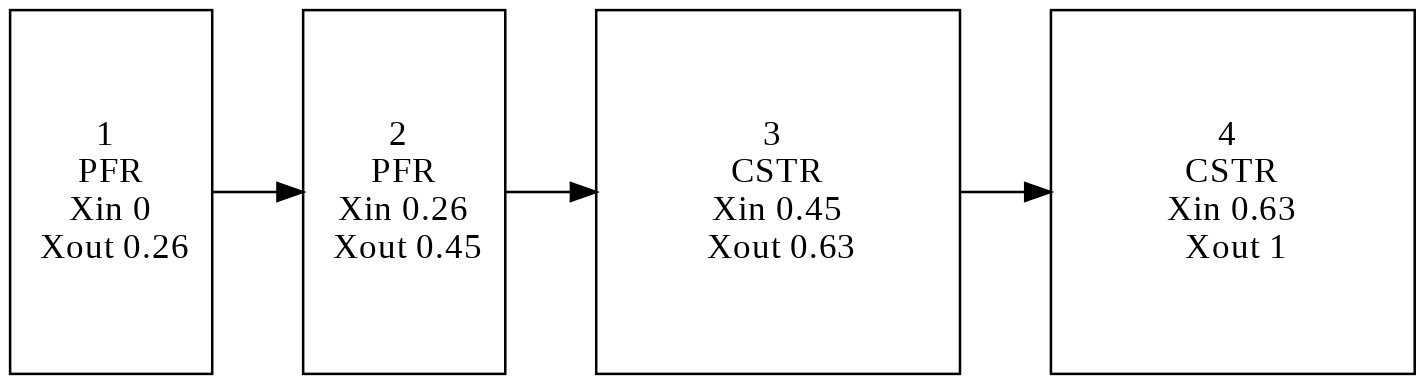

In [96]:
import PIL.Image
import IPython.display
IPython.display.display(PIL.Image.fromarray(image_list[-1]))